In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
import timm
from PIL import Image
import numpy as np
from torchvision import transforms
import cv2

In [2]:
class ConvNeXtTransformer_concatGAP(nn.Module):
    def __init__(self, num_classes, nhead=8, dim_feedforward=4096, num_transformer_layers=1):
        super(ConvNeXtTransformer_concatGAP, self).__init__()
        self.features = timm.create_model('convnextv2_large.fcmae_ft_in22k_in1k_384', pretrained=True, num_classes=0, global_pool='')
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
        d_model = 1536
        self.layer_norm = nn.LayerNorm(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_transformer_layers, norm=nn.LayerNorm(d_model), enable_nested_tensor=False)
        self.classifier = nn.Linear(d_model*2, num_classes)
    
    def forward(self, x):
        self.saved_activations = {}
        x = self.features(x)
        # print(x.shape)
        self.saved_activations['convnext'] = x
        x_head = self.gap(x)
        # print(x_head.shape)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = self.layer_norm(x)
        x = self.transformer_encoder(x)
        self.saved_activations['transformer'] = x
        x = x.permute(0, 2, 1)
        # self.saved_activations['transformer'] = x.permute(0, 2, 1)
        x = torch.mean(x, dim=2)
        x = torch.cat((x_head.view(1, 1536), x), dim=1)
        x = self.classifier(x)
        return x


def load_image(img_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = cv2.imread(img_path)
    return transform(img).unsqueeze(0)

def display_heatmap(original_img, heatmap, alpha=0.5):
    """
    显示原始图像与热图的叠加效果。
    参数:
    - original_img: PIL.Image 或 numpy array，原始图像。
    - heatmap: numpy array，热图数据。
    - alpha: float，热图的透明度。
    """
    # 如果original_img是PIL.Image，转换为numpy array
    if isinstance(original_img, Image.Image):
        original_img = np.array(original_img)
    
    # 确保热图的尺寸与原图相同
    heatmap_resized = np.uint8(255 * heatmap)  # 转换为0-255范围
    heatmap_resized = plt.cm.jet(heatmap_resized)[:, :, :3]  # 应用颜色映射
    heatmap_resized = np.uint8(heatmap_resized * 255)  # 再次转换为0-255范围
    heatmap_resized = Image.fromarray(heatmap_resized).resize(original_img.shape[1::-1], Image.BILINEAR)

    # 创建图像显示
    fig, ax = plt.subplots()
    ax.imshow(original_img, alpha=1.0)
    ax.imshow(heatmap_resized, alpha=alpha)  # 叠加热图
    ax.axis('off')  # 不显示坐标轴
    plt.show()


def grad_cam(model, img_tensor, target_layer_key, labels, class_index):
    model.eval()
    
    gradients = []
    def save_grads_hook(module, grad_input, grad_output):
        # print(grad_output[0].shape)
        gradients.append(grad_output[0])

    if target_layer_key == 'convnext':
        target_layer = model.features
    elif target_layer_key == 'transformer':
        target_layer = model.transformer_encoder
    hook_handle = target_layer.register_full_backward_hook(save_grads_hook)

    output = model(img_tensor)
    probabilities = F.sigmoid(output)
    predictions = probabilities > 0.5
    # print(f"Model output: {predictions}")
    predicted_categories_index = [i for i in range(len(predictions[0])) if predictions[0, i]]
    print(f"Model output predicted_categories_index: {predicted_categories_index}")
    # categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    # print(f"Predicted categories: {predicted_categories}")
    
    features = model.saved_activations[target_layer_key]
    # print(features)
    features.retain_grad()

    model.zero_grad()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    # print(output.shape, labels.shape)
    # loss = loss_fn(output, labels)
    loss = sum([output[0,class_index]])
    loss.backward()

    if not gradients:
        raise ValueError("No gradients were captured - likely an issue with the backward hook.")

    if target_layer_key == 'convnext':
        reshaped_gradients = gradients[0].permute(0, 2, 3, 1).clone()
        reshaped_features = features.permute(0, 2, 3, 1).clone()
    elif target_layer_key == 'transformer':
        reshaped_gradients = gradients[0].reshape(1, 12, 12, 1536).clone()
        reshaped_features = features.reshape(1, 12, 12, 1536).clone()
    
    pooled_gradients = torch.mean(reshaped_gradients, dim=[0, 1, 2])
    for i in range(reshaped_features.shape[-1]):
        reshaped_features[0, :, :, i] *= pooled_gradients[i]
    heatmap = torch.sum(reshaped_features, dim=3).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap = (heatmap - torch.min(heatmap)) / (torch.max(heatmap) - torch.min(heatmap) + 1e-8)

    hook_handle.remove()

    return heatmap.detach().cpu().numpy()


# Fundus images in MuReD dataset

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataloaders.multilabel_dataset import MultilabelDataset
import torch.nn.functional as F

model_path = './saved_models/myconvnext_2layer_concatGAP_1.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()

transform4test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])
test_dataset = MultilabelDataset(ann_dir='./data/fundus/MuReD/train_data.csv',
                                root_dir='./data/fundus/MuReD/images/images/',
                                num_labels=20,
                                transform=transform4test, known_labels=0, testing=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    

correct_images = []
for i, batch in enumerate(test_loader):
    inputs, labels = batch['image'].cuda(), batch['labels'].cuda()
    outputs = model(inputs)
    predicted = (F.sigmoid(outputs) > 0.5).float()
    predicted_index = [i for i in range(len(predicted[0])) if predicted[0, i]]
    # print(f"Predicted: {predicted}")
    # print(f"Labels: {labels}")
    correct = (predicted == labels).all()
    # print(f"Correct: {correct}")
    if correct:
        # print(f"{i+2}, {predicted}")
        correct_images.append((i+2, len(predicted_index)))
        # print(f"Correct image index: {i}")

correct_images

[(2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (53, 1),
 (54, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (77, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (100, 1),
 (103, 1),
 (105, 1),
 (106, 1),
 (107, 1),
 (108, 1),
 (109, 1),
 (110, 1),
 (111, 1),
 (113, 1),
 (114, 1),
 (115, 2),
 (117, 1),
 (118

In [6]:
# import pandas as pd

# df = pd.read_csv('./data/fundus/MuReD/train_data.csv')

# df['num_labels'] = df.iloc[:, 1:].sum(axis=1)

# images_with_four_labels = df[df['num_labels'] == 3]

# selected_images = images_with_four_labels['ID']
# print(selected_images.head(30))

index = [x for x, y in correct_images if y == 3]
index

[145,
 206,
 352,
 429,
 467,
 478,
 563,
 564,
 677,
 762,
 789,
 790,
 826,
 896,
 999,
 1097,
 1098,
 1102,
 1181,
 1338,
 1511,
 1530,
 1531,
 1681,
 1682,
 1684,
 1753]

In [8]:
model_path = './saved_models/myconvnext_2layer_concatGAP_1.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Model output predicted_categories_index: [6]
Model output predicted_categories_index: [6]


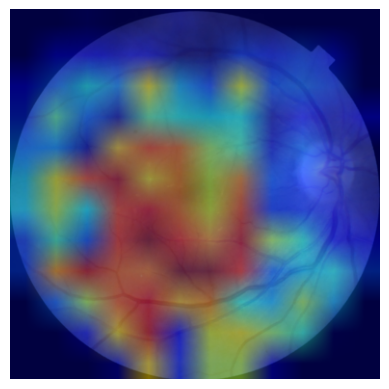

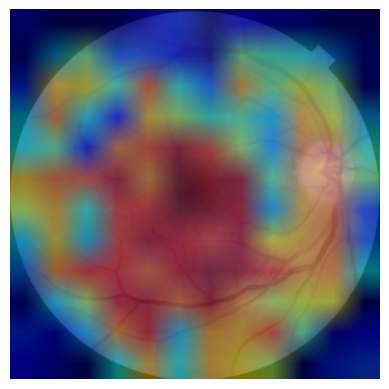

In [4]:
#### 1 label
img_tensor = load_image('./data/fundus/MuReD/images/images/988.png')
labels = torch.tensor([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 6)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 6)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Model output predicted_categories_index: [6]
Model output predicted_categories_index: [6]


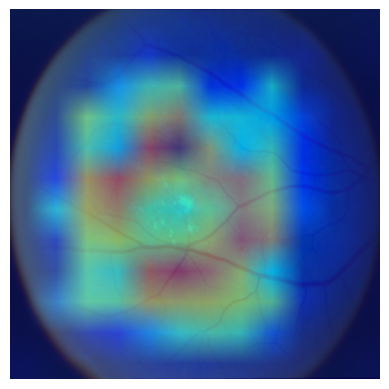

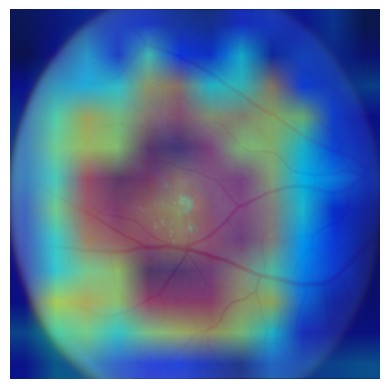

In [24]:
#### 2 label
img_tensor = load_image('./data/fundus/MuReD/images/images/im0307.png')
labels = torch.tensor([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 6)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 6)

# print(img_tensor.squeeze(0).permute(1, 2, 0).shape)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
# display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0)[:, :, [2, 1, 0]], convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Model output predicted_categories_index: [2, 3, 18]
Model output predicted_categories_index: [2, 3, 18]


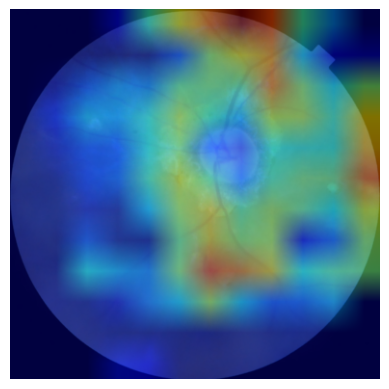

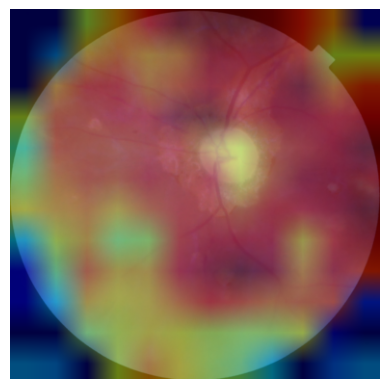

In [18]:
#### 3 label
img_tensor = load_image('./data/fundus/MuReD/images/images/804.png')
labels = torch.tensor([0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 18)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 18)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Model output predicted_categories_index: [5, 6, 16]
Model output predicted_categories_index: [5, 6, 16]


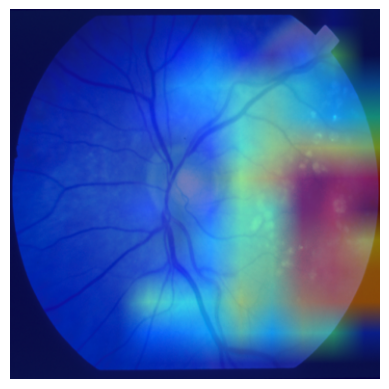

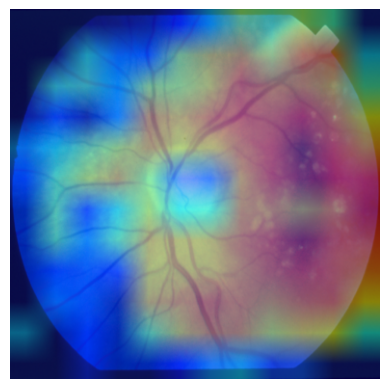

In [26]:
#### 4 label
img_tensor = load_image('./data/fundus/MuReD/images/images/im0265.png')
labels = torch.tensor([0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 5)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 5)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

# VOC 2012 dataset

In [33]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataloaders.multilabel_dataset import MultilabelDataset
import torch.nn.functional as F

model_path = './saved_models/myconvnext_2layer_concatGAP_voc2012.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()

transform4test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])
test_dataset = MultilabelDataset(ann_dir='./data/voc2012/train_val_label.csv',
                                root_dir='./data/voc2012/VOC2012_train_val/JPEGImages',
                                num_labels=20,
                                transform=transform4test, known_labels=0, testing=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    

correct_images = []
for i, batch in enumerate(test_loader):
    inputs, labels = batch['image'].cuda(), batch['labels'].cuda()
    outputs = model(inputs)
    predicted = (F.sigmoid(outputs) > 0.5).float()
    predicted_index = [i for i in range(len(predicted[0])) if predicted[0, i]]
    # print(f"Predicted: {predicted}")
    # print(f"Labels: {labels}")
    correct = (predicted == labels).all()
    # print(f"Correct: {correct}")
    if correct:
        # print(f"{i+2}, {predicted}")
        correct_images.append((i+2, len(predicted_index)))
        # print(f"Correct image index: {i}")

correct_images

[(2, 2),
 (3, 1),
 (4, 1),
 (5, 2),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (13, 2),
 (14, 1),
 (15, 2),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (26, 1),
 (27, 1),
 (29, 1),
 (32, 1),
 (33, 1),
 (34, 3),
 (37, 1),
 (38, 2),
 (39, 2),
 (40, 2),
 (41, 1),
 (42, 1),
 (43, 1),
 (45, 1),
 (47, 3),
 (48, 1),
 (50, 1),
 (51, 1),
 (54, 1),
 (55, 1),
 (57, 1),
 (58, 2),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (66, 1),
 (67, 1),
 (70, 1),
 (71, 1),
 (72, 2),
 (73, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (79, 2),
 (80, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 2),
 (94, 1),
 (96, 1),
 (97, 2),
 (98, 1),
 (100, 1),
 (101, 1),
 (102, 1),
 (103, 1),
 (104, 1),
 (105, 1),
 (107, 1),
 (108, 1),
 (109, 1),
 (110, 1),
 (112, 1),
 (113, 1),
 (114, 1),
 (115, 1),
 (118, 1),
 (119, 1),
 (120, 1),
 (121, 2),
 (122, 1),
 (123, 1),
 (125, 1),
 (126, 2),
 (127, 1),
 (12

In [34]:
index = [x for x, y in correct_images if y == 1]
index

[3,
 4,
 8,
 9,
 10,
 11,
 14,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 26,
 27,
 29,
 32,
 33,
 37,
 41,
 42,
 43,
 45,
 48,
 50,
 51,
 54,
 55,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 70,
 71,
 73,
 75,
 76,
 77,
 80,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 96,
 98,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 118,
 119,
 120,
 122,
 123,
 125,
 127,
 129,
 130,
 131,
 133,
 135,
 136,
 137,
 139,
 141,
 142,
 145,
 147,
 148,
 150,
 151,
 152,
 154,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 164,
 166,
 167,
 168,
 169,
 171,
 174,
 175,
 177,
 178,
 181,
 182,
 184,
 185,
 186,
 190,
 191,
 193,
 194,
 195,
 196,
 198,
 201,
 202,
 205,
 206,
 207,
 209,
 211,
 213,
 214,
 215,
 216,
 220,
 221,
 222,
 223,
 224,
 226,
 227,
 228,
 229,
 232,
 237,
 239,
 240,
 250,
 251,
 253,
 254,
 257,
 258,
 261,
 262,
 263,
 265,
 266,
 267,
 268,
 269,
 271,
 272,
 274,
 275,
 277,
 278,
 280,
 281,
 282,
 284,
 285,
 286,
 287,
 

In [35]:
index = [x for x, y in correct_images if y == 2]
index

[2,
 5,
 7,
 13,
 15,
 20,
 38,
 39,
 40,
 58,
 72,
 79,
 93,
 97,
 121,
 126,
 140,
 153,
 170,
 176,
 179,
 187,
 199,
 210,
 218,
 241,
 244,
 249,
 252,
 255,
 270,
 273,
 276,
 279,
 297,
 298,
 301,
 303,
 307,
 313,
 318,
 320,
 326,
 337,
 338,
 346,
 348,
 350,
 361,
 379,
 380,
 381,
 405,
 406,
 414,
 417,
 418,
 423,
 424,
 442,
 444,
 449,
 465,
 468,
 470,
 471,
 477,
 484,
 488,
 501,
 508,
 510,
 530,
 535,
 537,
 548,
 552,
 562,
 572,
 581,
 601,
 617,
 621,
 626,
 657,
 659,
 662,
 672,
 690,
 699,
 705,
 717,
 724,
 731,
 735,
 769,
 776,
 786,
 793,
 796,
 798,
 801,
 813,
 815,
 818,
 824,
 828,
 829,
 833,
 835,
 838,
 842,
 846,
 851,
 852,
 864,
 865,
 875,
 880,
 882,
 885,
 889,
 895,
 934,
 950,
 951,
 957,
 958,
 967,
 968,
 969,
 970,
 973,
 980,
 986,
 992,
 1007,
 1022,
 1024,
 1034,
 1043,
 1067,
 1075,
 1081,
 1101,
 1104,
 1107,
 1108,
 1115,
 1124,
 1126,
 1131,
 1137,
 1146,
 1150,
 1152,
 1154,
 1168,
 1171,
 1174,
 1185,
 1186,
 1190,
 1197,
 1200

In [36]:
index = [x for x, y in correct_images if y == 3]
index

[34,
 47,
 128,
 155,
 234,
 291,
 391,
 419,
 431,
 446,
 515,
 602,
 669,
 743,
 757,
 800,
 812,
 860,
 899,
 1001,
 1002,
 1134,
 1136,
 1158,
 1261,
 1390,
 1403,
 1434,
 1443,
 1458,
 1536,
 1586,
 1668,
 1671,
 1787,
 1893,
 1894,
 1941,
 1943,
 2013,
 2081,
 2146,
 2151,
 2203,
 2211,
 2249,
 2497,
 2509,
 2630,
 2671,
 2732,
 2745,
 2793,
 2837,
 2901,
 2958,
 2962,
 3019,
 3157,
 3162,
 3168,
 3181,
 3222,
 3227,
 3271,
 3289,
 3305,
 3366,
 3368,
 3392,
 3539,
 3562,
 3572,
 3725,
 3742,
 3806,
 3852,
 3917,
 3940,
 3990,
 4048,
 4059,
 4167,
 4226,
 4248,
 4253,
 4285,
 4297,
 4300,
 4337,
 4392,
 4458,
 4461,
 4579,
 4721,
 4740,
 4796,
 4882,
 4885,
 5008,
 5010,
 5061,
 5069,
 5087,
 5138,
 5186,
 5346,
 5361,
 5395,
 5529,
 5572,
 5596,
 5609,
 5625,
 5645,
 5669,
 5718,
 5750,
 5874,
 5879,
 5897,
 5940,
 5979,
 6134,
 6221,
 6384,
 6442,
 6541,
 6552,
 6559,
 6584,
 6612,
 6626,
 6631,
 6656,
 6685,
 6731,
 6744,
 6747,
 6844,
 6864,
 6891,
 6991,
 7044,
 7167,
 7281,

In [37]:
index = [x for x, y in correct_images if y == 4]
index

[544,
 646,
 830,
 1026,
 1235,
 1660,
 1703,
 1757,
 2071,
 2301,
 2993,
 3123,
 4784,
 4831,
 5011,
 5354,
 5630,
 6279,
 7107,
 7155,
 7421,
 7760,
 7787,
 8310,
 8702,
 8763,
 9390,
 9492,
 9532,
 9684,
 9690,
 9721,
 9963,
 10344,
 10507,
 10590,
 10930,
 11592,
 11997,
 12140,
 12543,
 12726,
 12761,
 12950,
 13125,
 13696,
 14442,
 14938,
 15008,
 15305,
 15870,
 16108,
 16879]

In [3]:
model_path = './saved_models/myconvnext_2layer_concatGAP_voc2012.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Ground truth categories : ['cow']
Attention_categories : cow
Model output predicted_categories_index: [9]
Model output predicted_categories_index: [9]


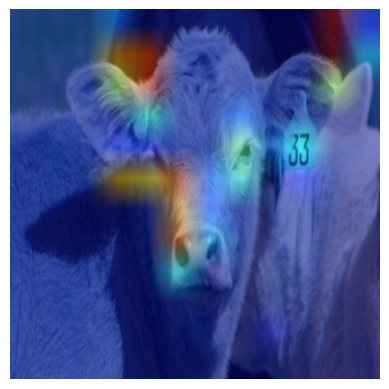

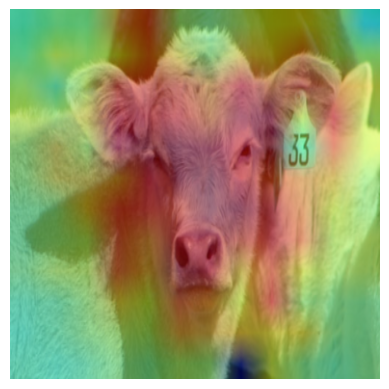

In [6]:
#### 1 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2008_008169.jpg')
labels = torch.tensor([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
ground_truth = [categories[i] for i in GT_categories_index]
print(f"Ground truth categories : {ground_truth}")
Attention_categories_index = GT_categories_index[0]
print(f"Attention_categories : {categories[Attention_categories_index]}")


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Ground truth categories : ['person', 'sofa']
Attention_categories : sofa
Model output predicted_categories_index: [14, 17]
Model output predicted_categories_index: [14, 17]


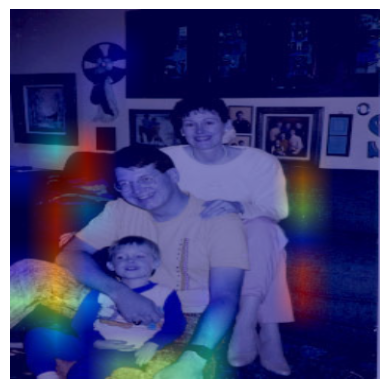

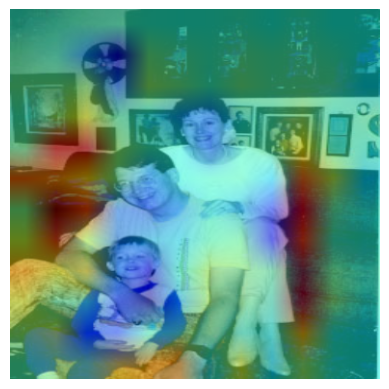

In [7]:
#### 2 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2008_004398.jpg')
labels = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
ground_truth = [categories[i] for i in GT_categories_index]
print(f"Ground truth categories : {ground_truth}")
Attention_categories_index = GT_categories_index[1]
print(f"Attention_categories : {categories[Attention_categories_index]}")

convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Ground truth categories : ['chair', 'diningtable', 'pottedplant']
Attention_categories : chair
Model output predicted_categories_index: [8, 10, 15]
Model output predicted_categories_index: [8, 10, 15]


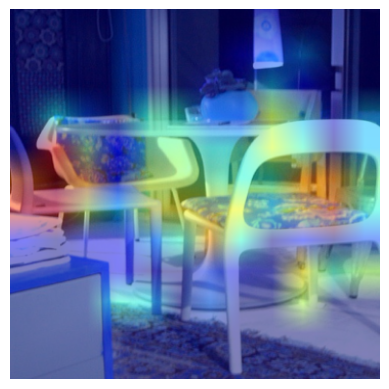

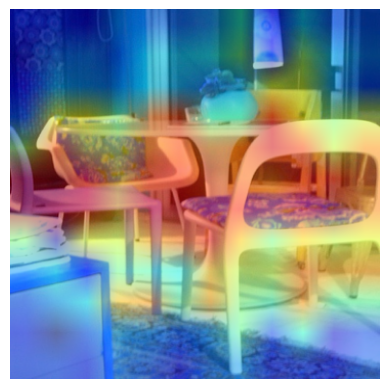

In [17]:
#### 3 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2010_002336.jpg')
labels = torch.tensor([0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
ground_truth = [categories[i] for i in GT_categories_index]
print(f"Ground truth categories : {ground_truth}")
Attention_categories_index = GT_categories_index[0]
print(f"Attention_categories : {categories[Attention_categories_index]}")

convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Ground truth categories : ['car', 'motorbike', 'person', 'pottedplant']
Attention_categories : car
Model output predicted_categories_index: [6, 13, 14, 15]
Model output predicted_categories_index: [6, 13, 14, 15]


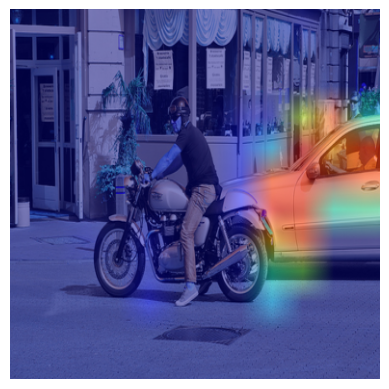

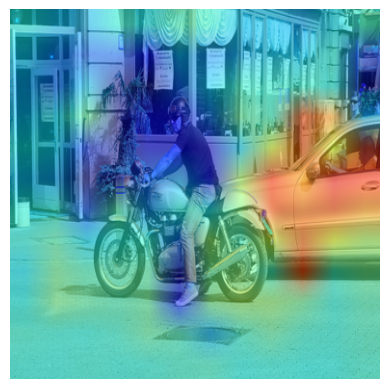

In [21]:
#### 4 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2009_003238.jpg')
labels = torch.tensor([0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
ground_truth = [categories[i] for i in GT_categories_index]
print(f"Ground truth categories : {ground_truth}")
Attention_categories_index = GT_categories_index[0]
print(f"Attention_categories : {categories[Attention_categories_index]}")

convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)